![](https://storage.googleapis.com/kaggle-competitions/kaggle/29762/logos/header.png)

# Context

The aim of this competition is to classify more than 81K landmark classes

# Libraries

We use some standard python packages and the libraries of scikit learn and keras. 

In [118]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical, Sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import RMSprop,Adam
from keras.applications import VGG19, VGG16, ResNet50, ResNet152V2, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization

import warnings
warnings.filterwarnings("ignore")

# Path

In [4]:
path = '../../landmark-recognition-2021/'
#path = '/kaggle/input/landmark-recognition-2021/'
os.listdir(path)

['test', 'train', 'sample_submission.csv', 'train.csv']

# Data

## Load

In [5]:
train_data = pd.read_csv(path+'train.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

In [6]:
train_data.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [7]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1


## Analyse

In [8]:
print("Mean picture per class : ",np.mean(train_data["landmark_id"].value_counts()))

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
134114       2
148173       2
179663       2
199396       2
25033        2
Name: landmark_id, Length: 81313, dtype: int64
Moyenne :  19.436867413574706


In [1]:
fig = plt.figure(figsize=(30, 15))
plt.boxplot(train_data["landmark_id"].value_counts(), vert=0)
plt.title("BoxPlot du nombre d'image par catégorie",fontsize=30)
plt.xticks(size=20)
plt.xlabel("Nbr Image",fontsize=20)
plt.show()

NameError: name 'plt' is not defined

In [10]:
# We keep 10 classes
indexToUse = train_data["landmark_id"].value_counts()[4:14].index
train_data = train_data.query('landmark_id in @indexToUse')
train_data=train_data.replace([9070, 168098, 46705,113209,177870,194914,149980,139894,1924,176528], [0,1, 2, 3, 4,5,6,7,8,9])

train_data.reset_index(drop=True, inplace=True)

113209    1135
177870    1088
194914    1073
149980     971
139894     966
1924       944
176528     920
9070       900
168098     888
46705      888
Name: landmark_id, dtype: int64


In [ ]:
print("Mean picture per class : ",np.mean(train_data["landmark_id"].value_counts()))

fig = plt.figure(figsize=(30, 15))
plt.boxplot(train_data["landmark_id"].value_counts(), vert=0)
plt.title("BoxPlot du nombre d'image par catégorie",fontsize=30)
plt.xticks(size=20)
plt.xlabel("Nbr Image",fontsize=20)
plt.show()

# Functions

In [11]:
def plot_examples(landmark_id=1):
    """ Plot 5 examples of images with the same landmark_id """
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = train_data[train_data['landmark_id']==landmark_id].index[i]
        image_id = train_data.loc[idx, 'id']
        file = image_id+'.jpg'
        subpath = '/'.join([char for char in image_id[0:3]])
        img = cv2.imread(path+'train/'+subpath+'/'+file)
        axs[i].imshow(img)
        axs[i].set_title('landmark_id: '+str(landmark_id))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [12]:
def ImgToTreat(img, toDisplay=False):  
    """ Image processing (histogram equalization and blur)"""
    imgBlur = img
    try:
        locImg=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        # Egalisation histogramme
        imgEq = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
        imgEq[:, :, 0] = cv2.equalizeHist(imgEq[:, :, 0])
        imgEq = cv2.cvtColor(imgEq,cv2.COLOR_YCrCb2RGB)
        # Lissage bruit
        imgBlur = cv2.blur(imgEq,(2,2))
    except Exception as e:
        print(e)
        pass
    if(toDisplay):
        fig = plt.figure(figsize=(30,15))
        plt.suptitle("Traitement image",fontsize=30)
        plt.subplot(1,3,1)
        plt.imshow(locImg)
        plt.title("Image de base",fontsize=20)
        plt.subplot(1,3,2)
        plt.imshow(imgEq)
        plt.title("Image de Egaliser",fontsize=20)
        plt.subplot(1,3,3)
        plt.imshow(imgBlur)
        plt.title("Image lissage bruit",fontsize=20)
        
        plt.show()
    return imgBlur

# Overview
First we look on the size of the dataset:

In [13]:
print('Samples train:', len(train_data))
print('Samples test:', len(samp_subm))

Samples train: 9773
Samples test: 10345


In [14]:
train_data.head()

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8
3,008e6817cf364cb6,8
4,00bad7a508ee6666,8


There are 81313 unique classes:

In [15]:
len(train_data['landmark_id'].unique())

10

For each test image, we have to predict one landmark label and a corresponding confidence score. 

In [16]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1


# Find Image
We consider the first image of the train data set and plot it. The first 3 characters ares used for the subpath which is the location of the image. 

In [17]:
train_data.head()

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8
3,008e6817cf364cb6,8
4,00bad7a508ee6666,8


In [18]:
image_id = train_data.loc[0, 'id']
file = image_id+'.jpg'
subpath = '/'.join([char for char in image_id[0:3]]) 

In [19]:
file

'00061e23ce736fa9.jpg'

In [20]:
subpath

'0/0/0'

Is the file located in the subpath?

In [21]:
file in os.listdir(path+'train/'+subpath)

True

In [22]:
path

'../../landmark-recognition-2021/'

Plot the image:

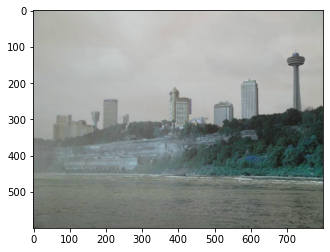

In [23]:
img = cv2.imread(path+'train/'+subpath+'/'+file)
plt.imshow(img)
plt.show()

Look on the image shape:

In [24]:
img.shape

(600, 800, 3)

# Plot Some Examples
We plot some examples of images with the same **landmark_id** in a row.

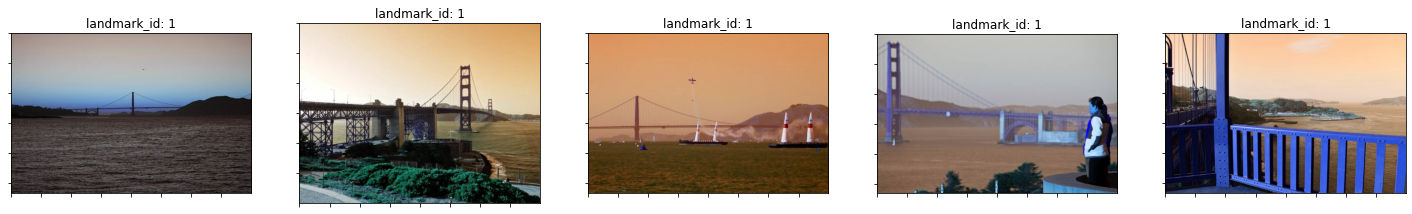

In [25]:
plot_examples(landmark_id = 1)

# Split Data
We define train, validation and test data.

In [26]:
train_data.index[0:3]

RangeIndex(start=0, stop=3, step=1)

In [27]:
list(train_data.index)[:15]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [28]:
list_IDs_trainA, list_IDs_valA = train_test_split(list(train_data.index)[:15], test_size=0.33, random_state=2021)
print('---- list_IDs_trainA -----')
print(list_IDs_trainA)
print('---list_IDs_valA-----')
print(list_IDs_valA)
print('-----------')
list_IDs_testA = list(samp_subm.index)[:15]
print('---- list_IDs_testA-----')
print(list_IDs_testA)
print('-----------')

---- list_IDs_trainA -----
[1, 10, 14, 8, 13, 6, 0, 9, 5, 4]
---list_IDs_valA-----
[3, 11, 7, 2, 12]
-----------
---- list_IDs_testA-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
-----------


In [29]:
train_data.iloc[train_data.index[0:3]]

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8


In [30]:
#500000
list_IDs_train, list_IDs_val = train_test_split(list(train_data.index)[:100000], test_size=0.33, random_state=2021)
list_IDs_test = list(samp_subm.index)

In [31]:
print('Number train samples:', len(list_IDs_train))
print('Number val samples:', len(list_IDs_val))
print('Number test samples:', len(list_IDs_test))

Number train samples: 6547
Number val samples: 3226
Number test samples: 10345


# Data Generator

We use a data generator to load the data on demand.

In [32]:
img_size = 32
img_channel = 3
batch_size = 64

num_classes = len(train_data['landmark_id'].value_counts())

In [33]:
num_classes

10

# DataGenerator

In [34]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, img_size, img_channel, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.img_size = img_size
        self.img_channel = img_channel
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel))
        y = np.zeros((self.batch_size, 1), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            
            image_id = self.data.loc[ID, 'id']
            file = image_id+'.jpg'
            subpath = '/'.join([char for char in image_id[0:3]]) 
            
            img = cv2.imread(self.path+subpath+'/'+file)
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img/255
            if self.path.find('train')>=0:
                y[i, ] = self.data.loc[ID, 'landmark_id']
            else:
                y[i, ] = 0
        return X, y

Use the DataGenerator class to define the data generators for train, validation and test data:

In [35]:
train_generator = DataGenerator(path+'train/', list_IDs_train, train_data, img_size, img_channel, batch_size)
val_generator = DataGenerator(path+'train/', list_IDs_val, train_data, img_size, img_channel, batch_size)
test_generator = DataGenerator(path+'test/', list_IDs_test, samp_subm, img_size, img_channel, batch_size)

# Model

Load pretrained model:

In [36]:
weights='imagenet'
conv_base = ResNet50(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))
conv_base.trainable = True

Define Model

In [37]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [38]:
epochs = 5

In [39]:
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = epochs, workers=4)

Epoch 1/5
103/103 [==============================] - 253s 2s/step - loss: 3.0896 - sparse_categorical_accuracy: 0.2452 - val_loss: 10.3370 - val_sparse_categorical_accuracy: 0.0974
Epoch 2/5
103/103 [==============================] - 235s 2s/step - loss: 0.9065 - sparse_categorical_accuracy: 0.7111 - val_loss: 32.8323 - val_sparse_categorical_accuracy: 0.0974
Epoch 3/5
 51/103 [=============>................] - ETA: 1:41 - loss: 0.3598 - sparse_categorical_accuracy: 0.8913

KeyboardInterrupt: 

In [ ]:
print("Train done")

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
history.history['loss']

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Learning Loss","Validation Loss"],fontsize=10)

In [ ]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

# Test DataAugmentation

In [44]:
len(train_data)

9773

In [45]:
train_data.head()

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8
3,008e6817cf364cb6,8
4,00bad7a508ee6666,8


In [47]:
image_id = train_data.loc[0, 'id']
file = image_id+'.jpg'
subpath = '/'.join([char for char in image_id[0:3]]) 
subpath

'0/0/0'

In [54]:
type(train_data)

pandas.core.frame.DataFrame

In [75]:
labels = []
image_path = []
images_pixels = []
for row in train_data.itertuples():
    image_id = row.id
    file = image_id+'.jpg'
    subpath = '/'.join([char for char in image_id[0:3]]) 
    finalpath = path+"/train/"+subpath+'/'+file

    img = cv2.imread(finalpath)
    img = cv2.resize(img, (img_size, img_size))
    img = ImgToTreat(img,False)

    images_pixels.append(img)
    image_path.append(finalpath)
    labels.append(row.landmark_id)  

In [84]:
X_train, X_val, Y_train, Y_val = train_test_split(images_pixels,
                                                  labels, test_size = 0.3, 
                                                  random_state=101)
print("X train data : ", len(X_train))
print("X label data : ", len(X_val))
print("Y test data : ", len(Y_train))
print("Y label data : ", len(Y_val))

X train data :  6841
X label data :  2932
Y test data :  6841
Y label data :  2932


In [87]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

training_set = datagen.flow(np.array(X_train),np.array(Y_train),batch_size=16)

In [91]:
history = model.fit_generator(training_set,
                              validation_data=(np.array(X_val),np.array(Y_val)),
                              epochs = epochs, workers=4)

Epoch 1/5
428/428 [==============================] - 531s 1s/step - loss: 1.5906 - sparse_categorical_accuracy: 0.4992 - val_loss: 1577.4647 - val_sparse_categorical_accuracy: 0.0883
Epoch 2/5
428/428 [==============================] - 513s 1s/step - loss: 1.3625 - sparse_categorical_accuracy: 0.5717 - val_loss: 2446.9138 - val_sparse_categorical_accuracy: 0.0706
Epoch 3/5
428/428 [==============================] - 502s 1s/step - loss: 1.3008 - sparse_categorical_accuracy: 0.5851 - val_loss: 1548.6887 - val_sparse_categorical_accuracy: 0.0952
Epoch 4/5
428/428 [==============================] - 482s 1s/step - loss: 1.2024 - sparse_categorical_accuracy: 0.6088 - val_loss: 2933.0869 - val_sparse_categorical_accuracy: 0.0883
Epoch 5/5
428/428 [==============================] - 516s 1s/step - loss: 1.1478 - sparse_categorical_accuracy: 0.6327 - val_loss: 1299.0182 - val_sparse_categorical_accuracy: 0.0952


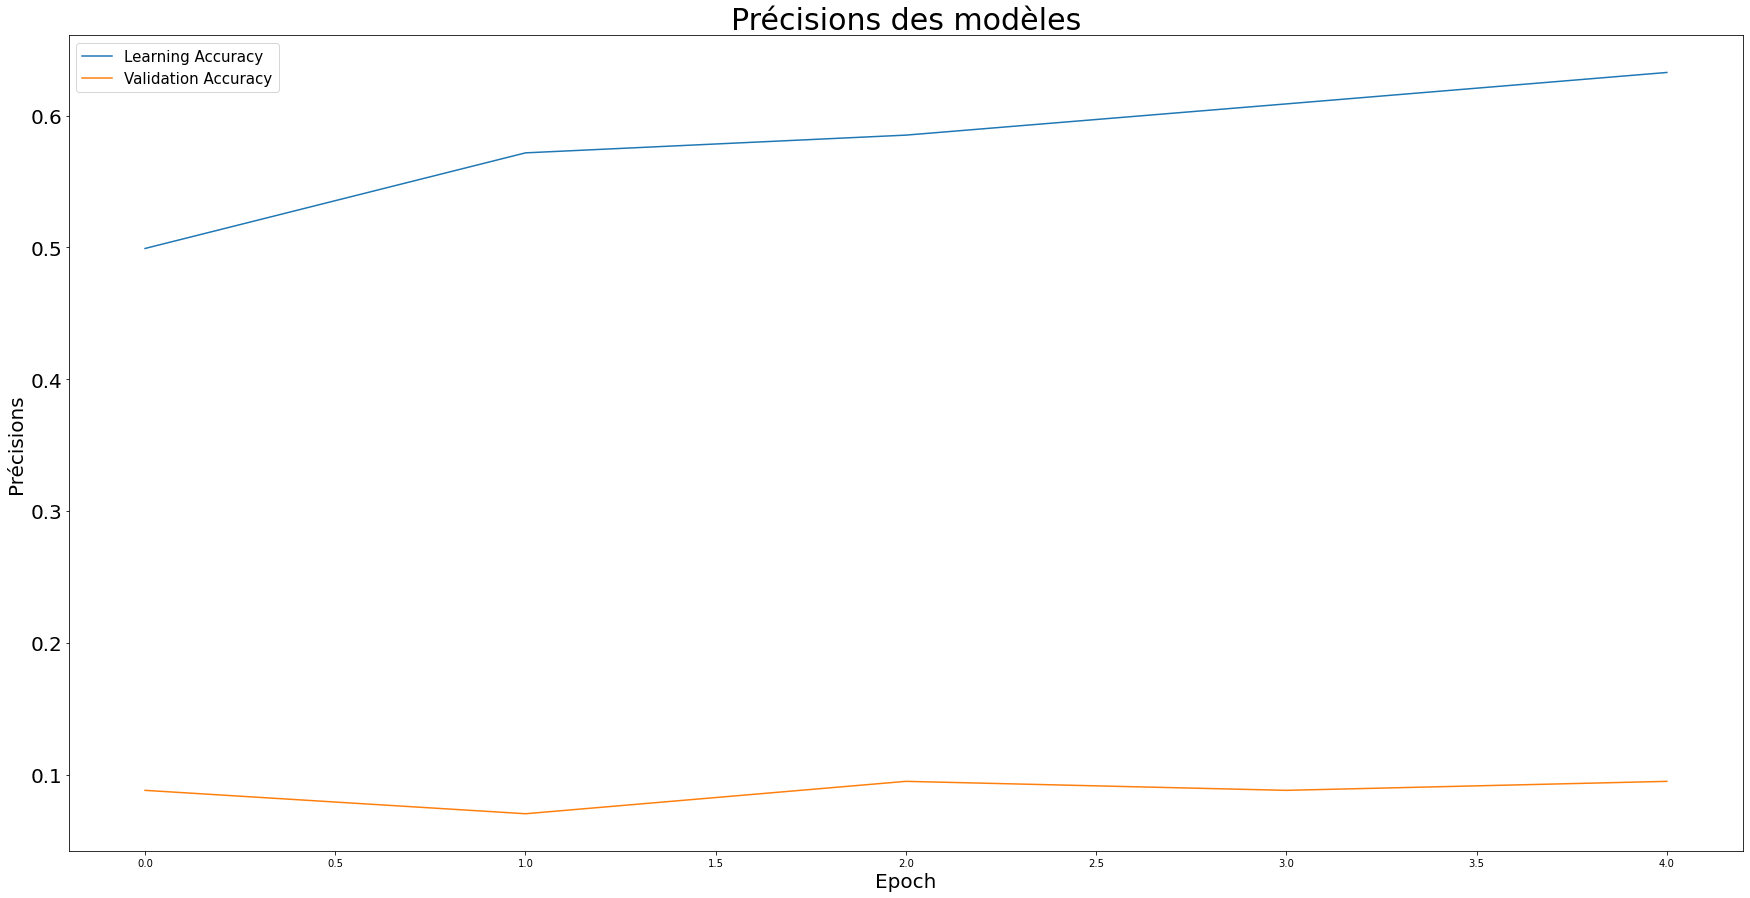

In [92]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

In [93]:
weights='imagenet'
conv_base = ResNet50(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))
conv_base.trainable = True

# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in conv_base.layers[:5]:
   layer.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,545,482
Non-trainable params: 62,720
_________________________________________________________________


In [94]:
history = model.fit_generator(training_set,
                              validation_data=(np.array(X_val),np.array(Y_val)),
                              epochs = epochs, workers=4)

Epoch 1/5
428/428 [==============================] - 510s 1s/step - loss: 3.0726 - sparse_categorical_accuracy: 0.1973 - val_loss: 391.2138 - val_sparse_categorical_accuracy: 0.1149
Epoch 2/5
428/428 [==============================] - 513s 1s/step - loss: 1.9816 - sparse_categorical_accuracy: 0.3846 - val_loss: 2394.1650 - val_sparse_categorical_accuracy: 0.0948
Epoch 3/5
428/428 [==============================] - 516s 1s/step - loss: 1.5769 - sparse_categorical_accuracy: 0.4871 - val_loss: 2145.2517 - val_sparse_categorical_accuracy: 0.0948
Epoch 4/5
428/428 [==============================] - 485s 1s/step - loss: 1.4312 - sparse_categorical_accuracy: 0.5469 - val_loss: 2862.6287 - val_sparse_categorical_accuracy: 0.0986
Epoch 5/5
428/428 [==============================] - 530s 1s/step - loss: 1.3205 - sparse_categorical_accuracy: 0.5807 - val_loss: 1153.9401 - val_sparse_categorical_accuracy: 0.0624


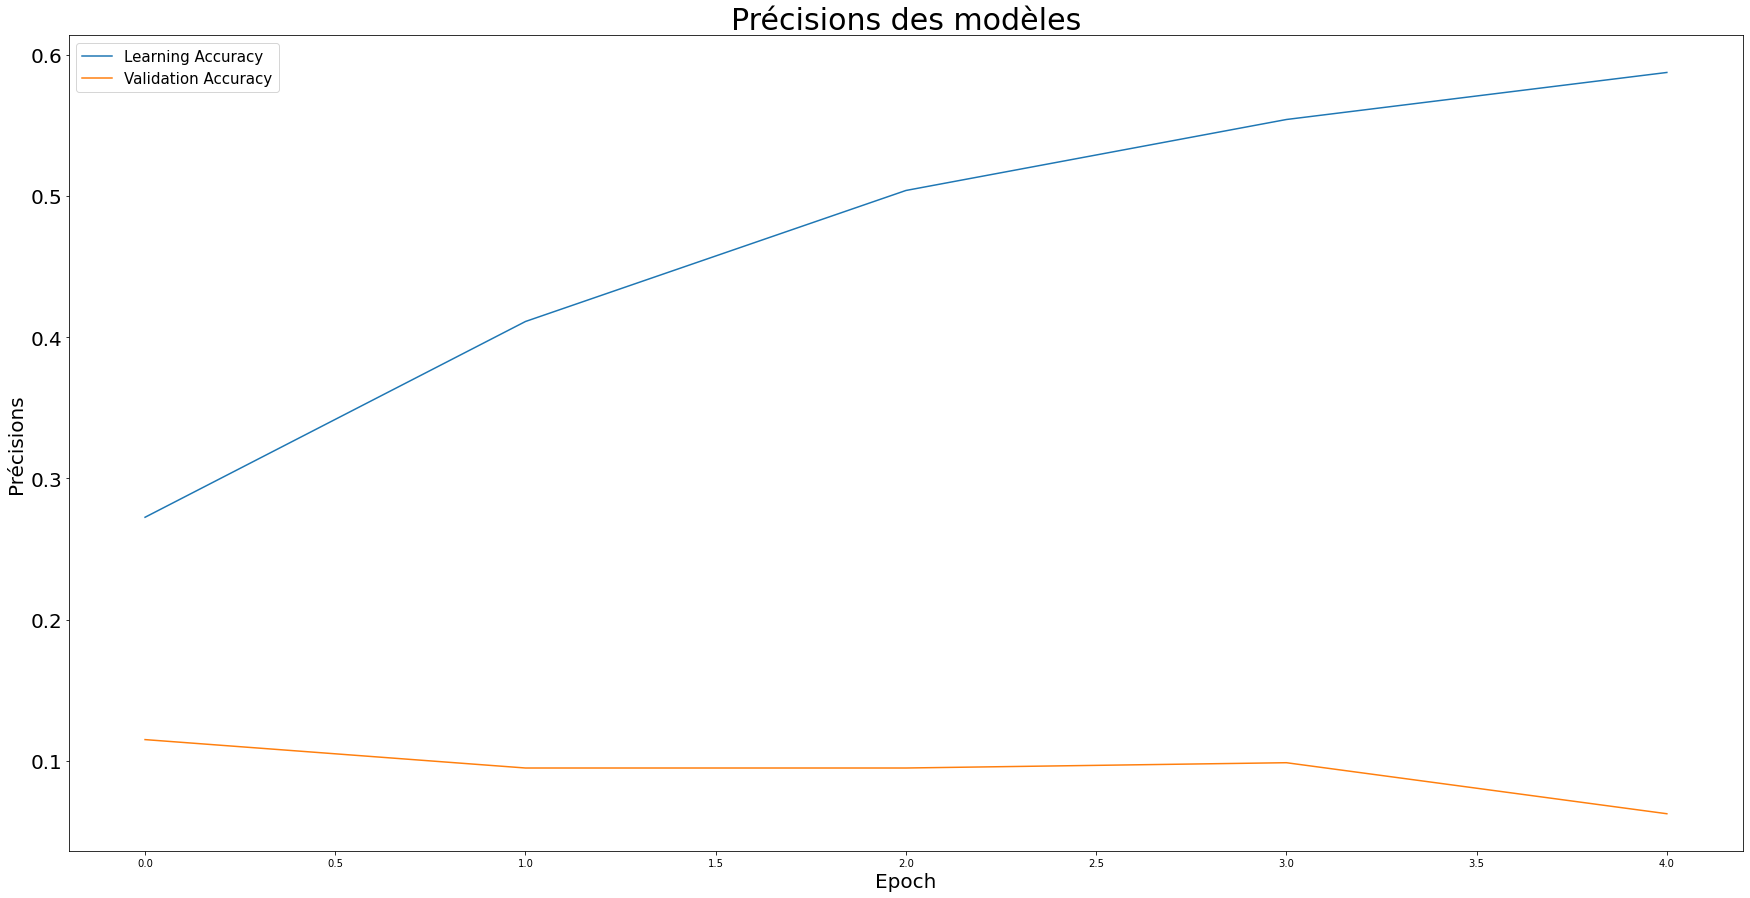

In [95]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

In [98]:
weights='imagenet'
conv_base = ResNet50(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))

# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in conv_base.layers:
   layer.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [99]:
history = model.fit_generator(training_set,
                              validation_data=(np.array(X_val),np.array(Y_val)),
                              epochs = epochs, workers=4)

Epoch 1/5
428/428 [==============================] - 73s 164ms/step - loss: 3.1284 - sparse_categorical_accuracy: 0.1010 - val_loss: 6.4058 - val_sparse_categorical_accuracy: 0.0720
Epoch 2/5
428/428 [==============================] - 70s 163ms/step - loss: 2.7527 - sparse_categorical_accuracy: 0.1084 - val_loss: 6.3751 - val_sparse_categorical_accuracy: 0.0692
Epoch 3/5
428/428 [==============================] - 66s 155ms/step - loss: 2.6288 - sparse_categorical_accuracy: 0.1105 - val_loss: 6.3506 - val_sparse_categorical_accuracy: 0.0689
Epoch 4/5
428/428 [==============================] - 71s 165ms/step - loss: 2.5194 - sparse_categorical_accuracy: 0.1161 - val_loss: 6.3838 - val_sparse_categorical_accuracy: 0.0679
Epoch 5/5
428/428 [==============================] - 71s 166ms/step - loss: 2.4703 - sparse_categorical_accuracy: 0.1214 - val_loss: 6.3892 - val_sparse_categorical_accuracy: 0.0716


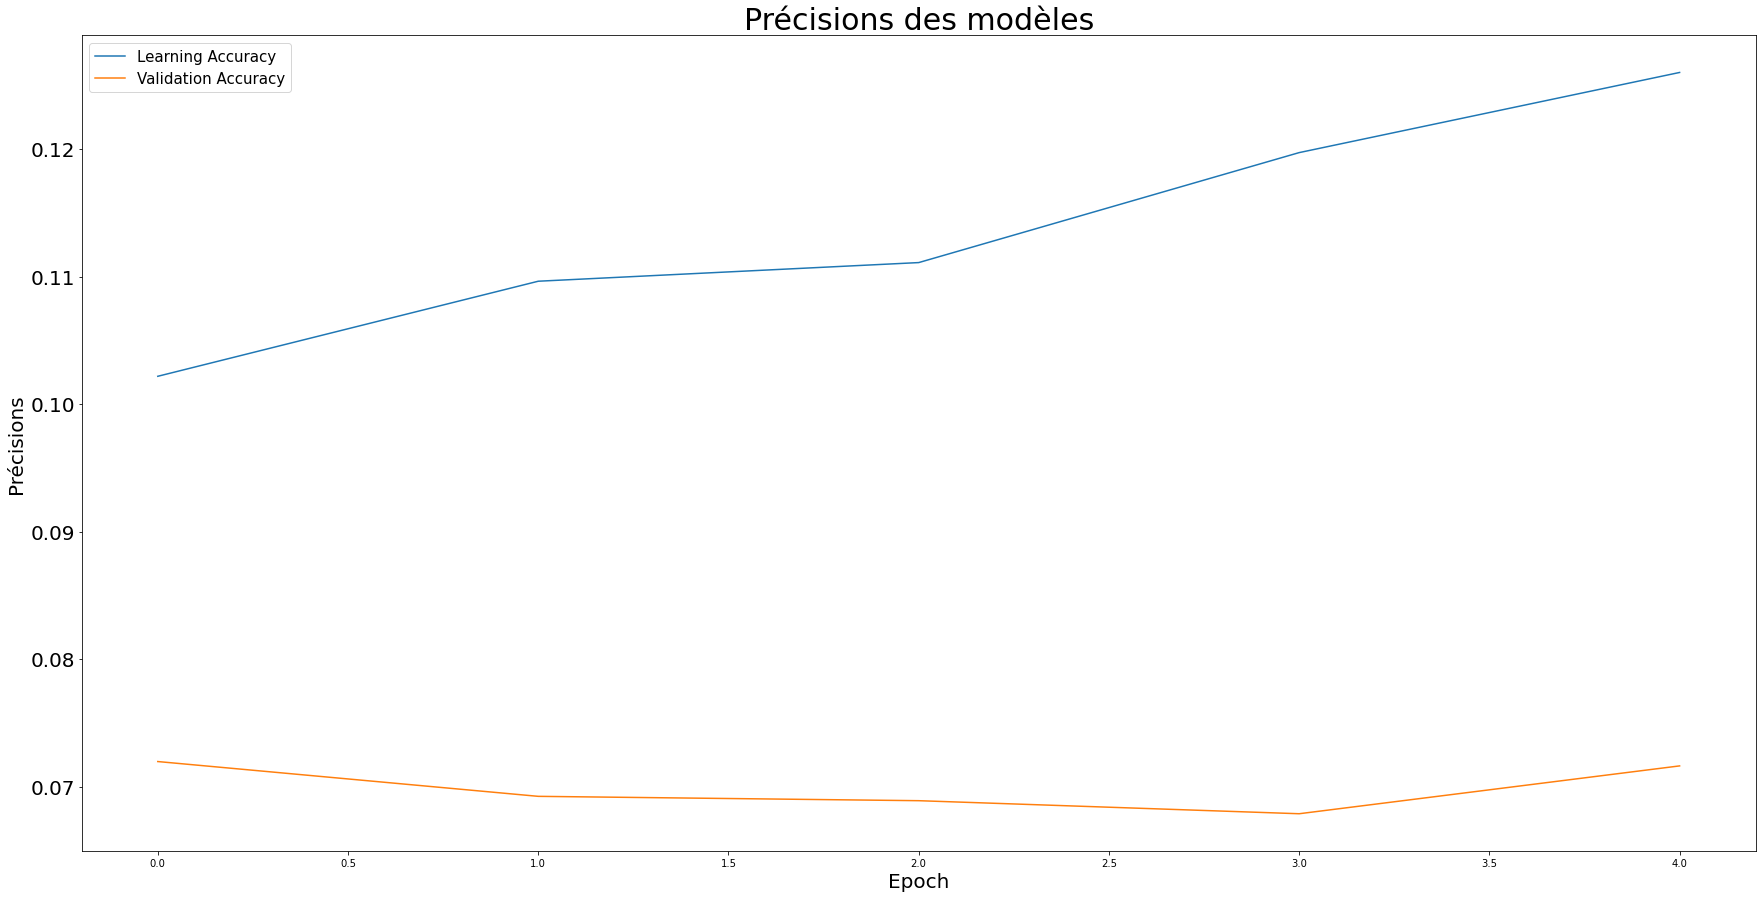

In [100]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

In [102]:
weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
conv_base = ResNet50(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))
conv_base.trainable = True

# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in conv_base.layers[:5]:
   layer.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,545,482
Non-trainable params: 62,720
_________________________________________________________________


In [103]:
history = model.fit_generator(training_set,
                              validation_data=(np.array(X_val),np.array(Y_val)),
                              epochs = epochs, workers=4)

Epoch 1/5
428/428 [==============================] - 536s 1s/step - loss: 3.0434 - sparse_categorical_accuracy: 0.2011 - val_loss: 323.1689 - val_sparse_categorical_accuracy: 0.0859
Epoch 2/5
428/428 [==============================] - 526s 1s/step - loss: 2.0016 - sparse_categorical_accuracy: 0.3978 - val_loss: 1480.9283 - val_sparse_categorical_accuracy: 0.1033
Epoch 3/5
428/428 [==============================] - 547s 1s/step - loss: 1.6523 - sparse_categorical_accuracy: 0.4687 - val_loss: 2881.0964 - val_sparse_categorical_accuracy: 0.1259
Epoch 4/5
428/428 [==============================] - 530s 1s/step - loss: 1.4384 - sparse_categorical_accuracy: 0.5417 - val_loss: 2621.4165 - val_sparse_categorical_accuracy: 0.0645
Epoch 5/5
428/428 [==============================] - 533s 1s/step - loss: 1.2964 - sparse_categorical_accuracy: 0.5816 - val_loss: 2563.5225 - val_sparse_categorical_accuracy: 0.0982


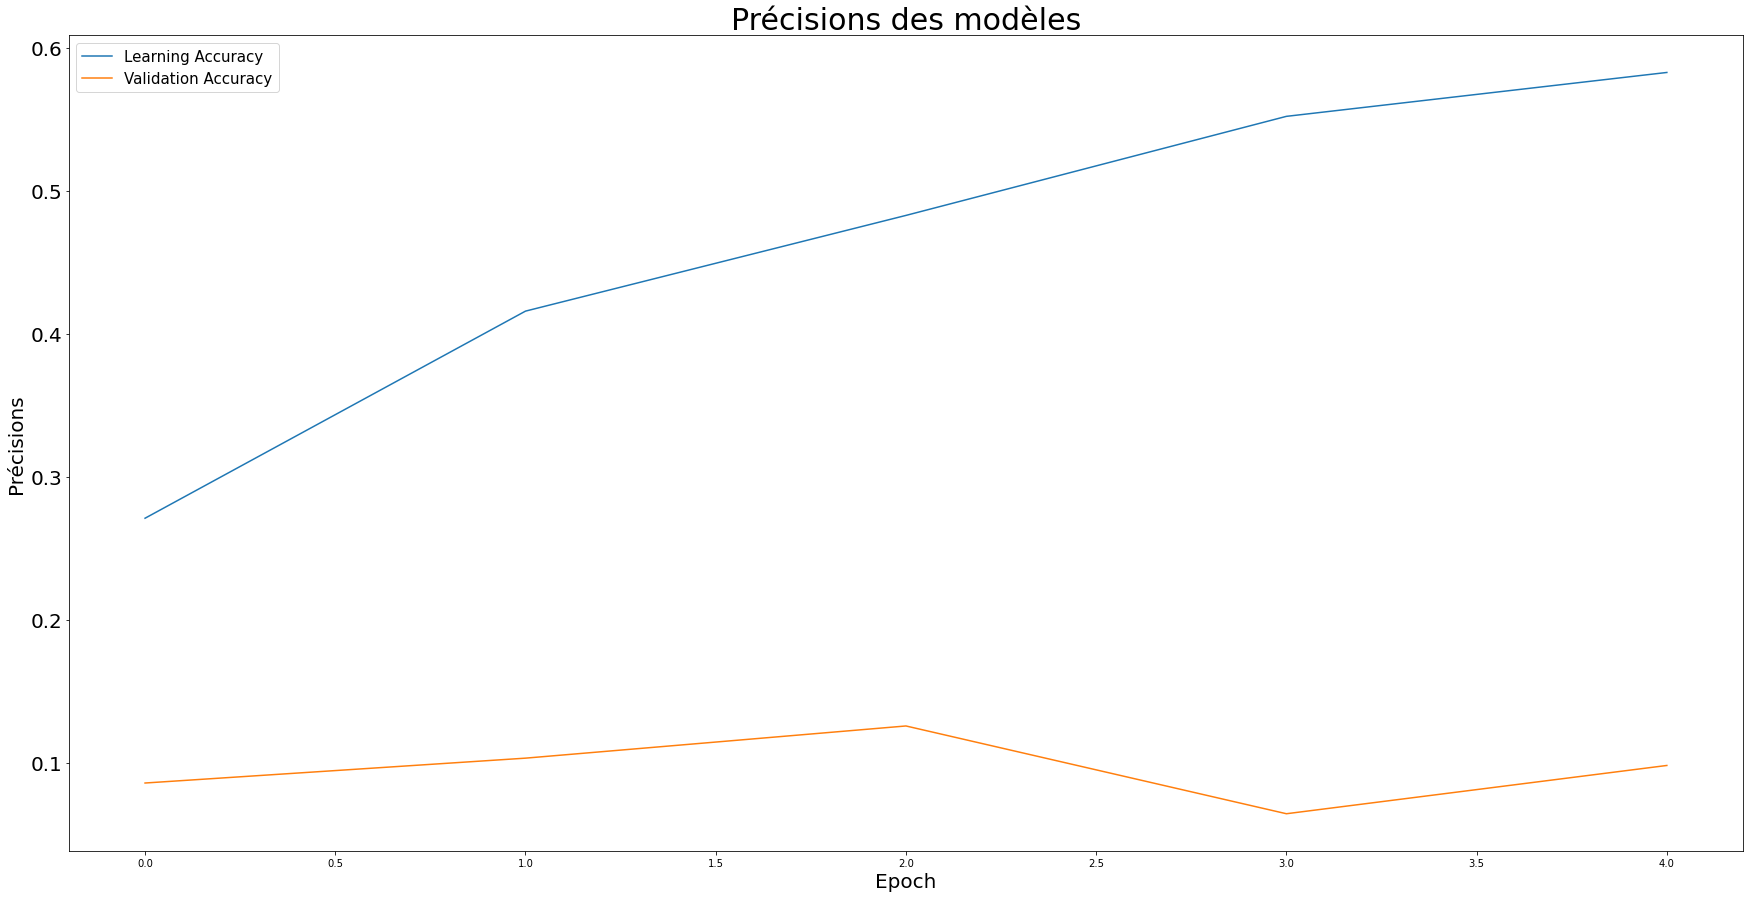

In [104]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

In [122]:
img_size = 224
img_channel = 3
batch_size = 64

In [123]:
weights='imagenet'
conv_base = NASNetMobile(weights=weights,
                     include_top=False,
                    input_shape=(224,224,3))
conv_base.trainable = True

# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in conv_base.layers[:5]:
   layer.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_10 (Flatten)         (None, 51744)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 51744)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 51744)             206976    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1655840   
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
activation_1129 (Activation) (None, 32)              

In [125]:
labels = []
image_path = []
images_pixels = []
for row in train_data.itertuples():
    image_id = row.id
    file = image_id+'.jpg'
    subpath = '/'.join([char for char in image_id[0:3]]) 
    finalpath = path+"/train/"+subpath+'/'+file

    img = cv2.imread(finalpath)
    img = cv2.resize(img, (img_size, img_size))
    img = ImgToTreat(img,False)

    images_pixels.append(img)
    image_path.append(finalpath)
    labels.append(row.landmark_id) 

In [126]:
X_train, X_val, Y_train, Y_val = train_test_split(images_pixels,
                                                  labels, test_size = 0.3, 
                                                  random_state=101)
print("X train data : ", len(X_train))
print("X label data : ", len(X_val))
print("Y test data : ", len(Y_train))
print("Y label data : ", len(Y_val))

X train data :  6841
X label data :  2932
Y test data :  6841
Y label data :  2932


In [127]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

training_set = datagen.flow(np.array(X_train),np.array(Y_train),batch_size=16)

In [ ]:
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    training_set,
    validation_data=(np.array(X_val),np.array(Y_val)),
    epochs=epochs, verbose=1,
    callbacks=[checkpoint])

Epoch 1/5
133/428 [========>.....................] - ETA: 59:14 - loss: 2.0851 - sparse_categorical_accuracy: 0.2867

In [ ]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

# Predict Test Data

In [44]:
y_pred = model.predict_generator(test_generator, verbose=1)

162/162 [==============================] - 114s 701ms/step


In [45]:
y_pred.shape

(10368, 81313)

In [46]:
for i in range(len(samp_subm.index)):
    category = np.argmax(y_pred[i])
    score = y_pred[i][np.argmax(y_pred[i])].round(2)
    samp_subm.loc[i, 'landmarks'] = str(category)+' '+str(score)

In [47]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,7314 0.06
1,000b15b043eb8cf0,3732 0.09
2,0011a52f9b948fd2,3092 0.06
3,00141b8a5a729084,8834 0.02
4,0018aa4b92532b77,10419 0.07


# Export

In [48]:
samp_subm.to_csv('submission.csv', index=False)